# Playground

## Load

In [2]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [3]:
from m5 import __data__

In [4]:
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [5]:
ds_all = load_ds()
# ds_all = load_ds(recalc=True)
ds = ds_all.where(ds_all['historic'], drop=True)
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## EDA

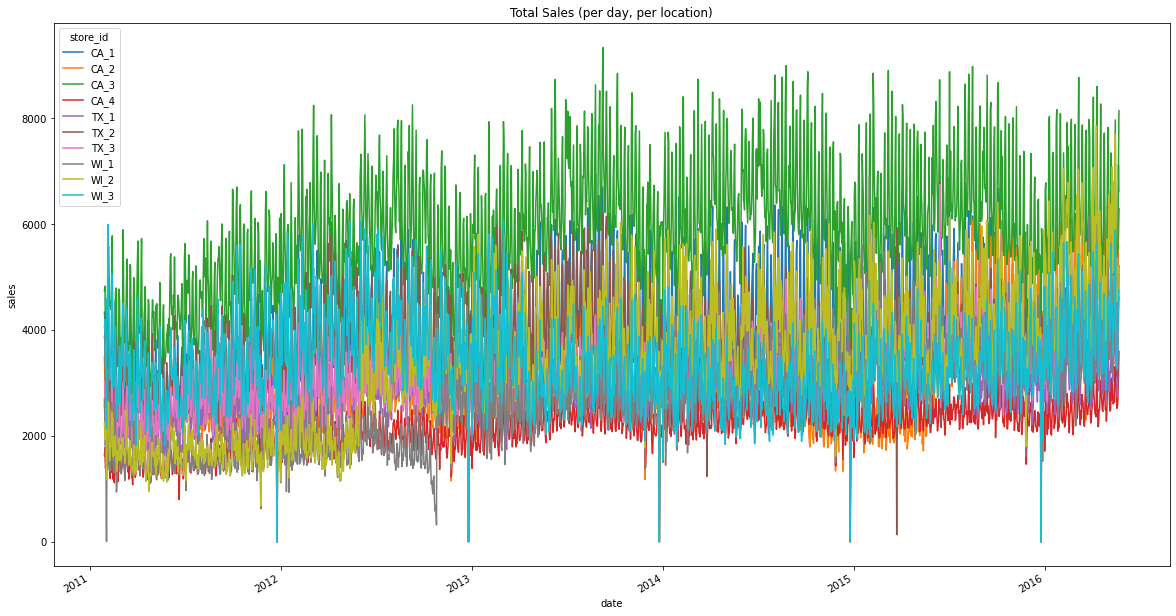

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
ds['sales'].sum(dim='item_id').plot.line(x='date', ax=ax)
ax.set_title("Total Sales (per day, per location)")
fig;

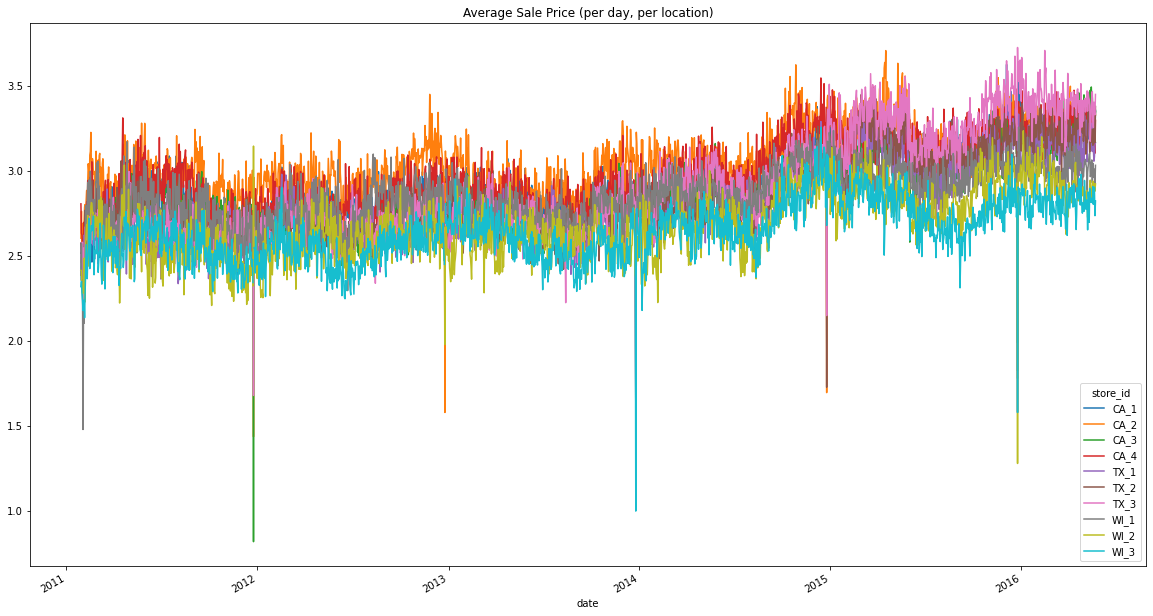

In [7]:
avg_price = (ds['sales'] * ds['price']).sum(dim='item_id') / ds['sales'].sum(dim='item_id')
fig, ax = plt.subplots(figsize=(20, 10))
avg_price.plot.line(x='date', ax=ax)
ax.set_title("Average Sale Price (per day, per location)")
fig;

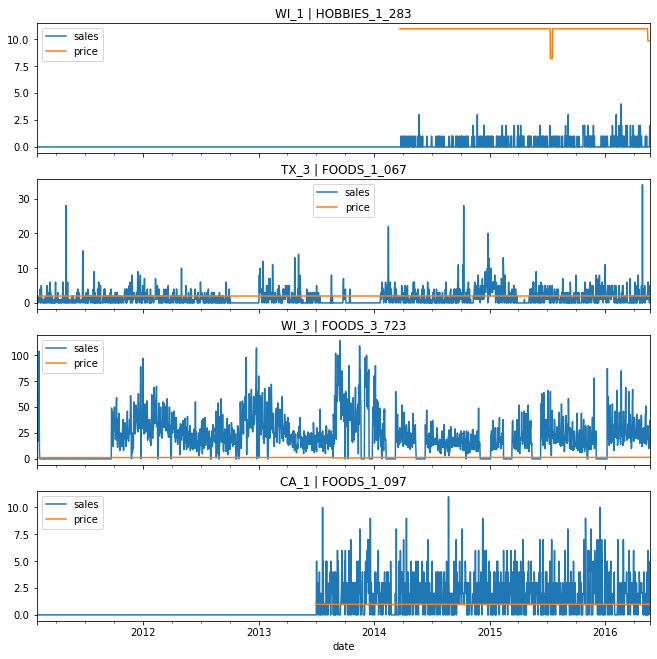

In [8]:
N = 4
fig, axs = plt.subplots(N, 1, squeeze=False, sharex=True, figsize=(11, 11),)
rng = np.random.default_rng(40)
for i in range(N):
    ax = axs[i,0]
    i_item = rng.choice(len(ds['item_id']))
    i_store = rng.choice(len(ds['store_id']))
    
    cols = ["sales", "price"]
    _q = ds[cols].isel({"store_id": i_store, "item_id": i_item})
    _q.to_dataframe()[cols].plot(ax=ax)
    
    item = _q['item_id'].item()
    store = _q['store_id'].item()
    
    ax.set_title(f"{store} | {item}")
    ax.legend()
fig;

## Prepare Dataset

We will select only `"FOODS"` in store `"CA_1"`.

In [15]:
ds_me = ds.where(ds["cat_id"]=="FOODS", drop=True).where(ds["store_id"] == "CA_1", drop=True)

In [16]:
fname = __data__ / "df_with_lags.parquet"
if fname.exists():
    df = pd.read_parquet(fname).set_index(["date", "item_id", "store_id"])
    
else:
    _cols_1 = ["sales", 'price', 'wday', 'month', 'snap', 'dept_id', 'cat_id', 'state_id']
    df = ds_me[_cols_1].to_dataframe()[_cols_1].dropna()
    
    df = pd.get_dummies(df, columns=['wday', 'month', 'cat_id'], drop_first=True)
    for i in range(1, 4):
        df[f'sales_lag_{i}'] = df['sales'].groupby(["item_id", "store_id"]).shift(i, fill_value=0)
    df.reset_index(drop=False).to_parquet(fname)

In [9]:
# df_events = ds['event'].to_series().unstack("event_name")
# df_res = df_w_dummies.merge(df_events, on='date', how='left')

In [ ]:
df.sample(5)

In [21]:
y = df["sales"]
x = df.drop(columns=["sales", "dept_id", "state_id"])

### Select Train/Valid indices

In [22]:
len(y.index)

2260241

In [24]:
train = y.sample(frac=0.8, random_state=42).index
valid = y.index.difference(train)

## Simple models

### Poisson regression

In [76]:
glm_proto = sm.GLM(
    y.loc[train], sm.add_constant(x.loc[train]), 
    family=sm.families.Poisson(),
)

In [77]:
glm = glm_proto.fit()

In [78]:
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  sales   No. Observations:              1808193
Model:                            GLM   Df Residuals:                  1808170
Model Family:                 Poisson   Df Model:                           22
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.4558e+06
Date:                Tue, 25 May 2021   Deviance:                   8.1061e+06
Time:                        23:57:36   Pearson chi2:                 1.15e+07
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6695      0.002    759.896      0.000       1.665       1.674
price          -0.2383      0.000   -684.657      0.000      -0.239      -0.238
snap            0.0649      0.001     64.157      0.000       0.063       0.067
wday_2.0       -0.0003      0.002     -0.198      0.843      -0.003       0.003
wday_3.0       -0.3828      0.002   -218.941      0.000      -0.386      -0.379
wday_4.0       -0.4695      0.002   -262.155      0.000      -0.473      -0.466
wday_5.0       -0.4900      0.002   -270.090      0.000      -0.494      -0.486
wday_6.0       -0.4072      0.002   -228.015      0.000      -0.411      -0.404
wday_7.0       -0.2218      0.002   -131.012      0.000      -0.225      -0.218
month_2.0       0.0498      0.002     21.052      0.000       0.045       0.054
month_3.0       0.0414      0.002     17.868      0.000       0.037       0.046
month_4.0       0.0593      0.002     25.612      0.000       0.055       0.064
month_5.0       0.0638      0.002     27.504      0.000       0.059       0.068
month_6.0       0.0926      0.002     38.534      0.000       0.088       0.097
month_7.0       0.1026      0.002     43.117      0.000       0.098       0.107
month_8.0       0.0934      0.002     39.463      0.000       0.089       0.098
month_9.0      -0.1698      0.003    -67.327      0.000      -0.175      -0.165
month_10.0      0.0056      0.002      2.319      0.020       0.001       0.010
month_11.0     -0.0215      0.002     -8.774      0.000      -0.026      -0.017
month_12.0     -0.0163      0.002     -6.721      0.000      -0.021      -0.012
sales_lag_1     0.0054   2.08e-05    260.815      0.000       0.005       0.005
sales_lag_2     0.0097   2.57e-05    377.183      0.000       0.010       0.010
sales_lag_3     0.0100   1.32e-05    760.694      0.000       0.010       0.010
===============================================================================
"""

In [79]:
z = glm.predict(sm.add_constant(x.loc[valid]))

In [80]:
o1 = pd.DataFrame({"actual": y.loc[valid], "predicted": z})

In [81]:
o1.head()

actual  predicted
date       item_id     store_id                   
2011-01-29 FOODS_1_006 CA_1         0.0   3.320574
           FOODS_1_018 CA_1        17.0   4.183894
           FOODS_1_040 CA_1         5.0   3.490938
           FOODS_1_041 CA_1         2.0   3.158523
           FOODS_1_049 CA_1        10.0   3.158523

In [82]:
items = o1.index.levels[1]
N = min(5, len(items))

In [83]:
ep = pd.DataFrame({"MAE": [], "Relative MAE": []})
# pd.Series({"Total": }, name='MAE')
_m1 = (o1['actual']-o1['predicted']).abs().mean()
ep.loc["Overall"] = [_m1, _m1 / o1['actual'].mean()]
for i in range(N):
    v = o1.loc[:, items[i], :].groupby("date").sum()
    _m1 = (v["actual"] - v["predicted"]).abs().mean()
    ep.loc[items[i]] = [_m1, _m1 / v['actual'].mean()]
ep

,MAE,Relative MAE
Overall,2.895336,1.198907
FOODS_1_001,2.037313,2.789439
FOODS_1_002,0.662570,1.369311
FOODS_1_003,1.604192,1.813434
FOODS_1_004,7.773205,0.743813
FOODS_1_005,1.657169,1.479750


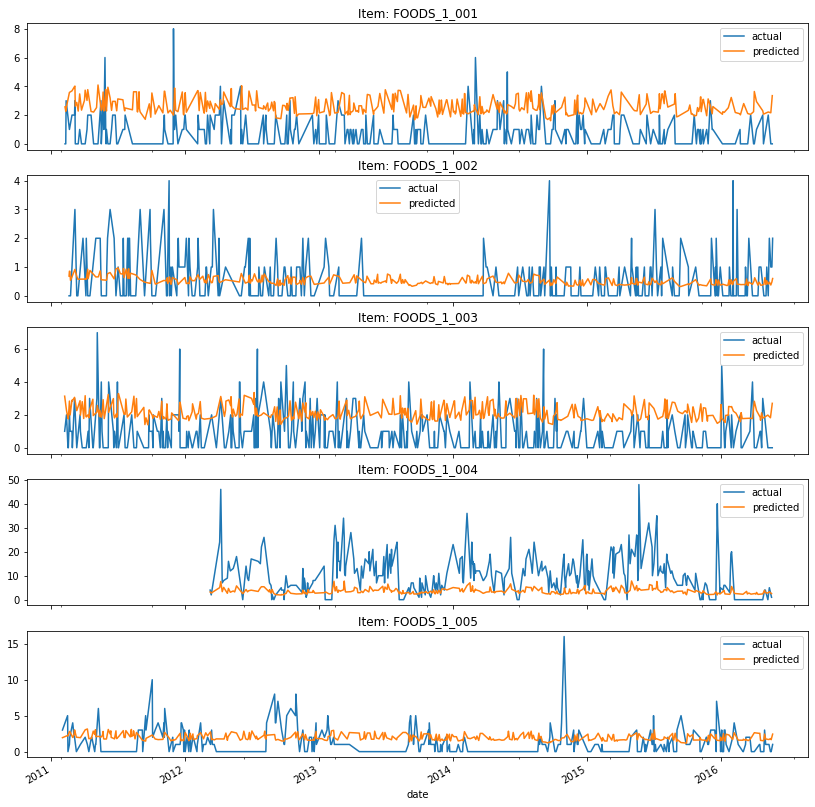

In [84]:
fig, axs = plt.subplots(N, 1, sharex=True, figsize=(14, 3 * N))
for i in range(N):
    ax=axs[i]
    v = o1.loc[:, items[i], :].groupby("date").sum()
    v.plot.line(ax=ax)
    ax.set_title(f"Item: {items[i]}")
    ax.legend()
fig;

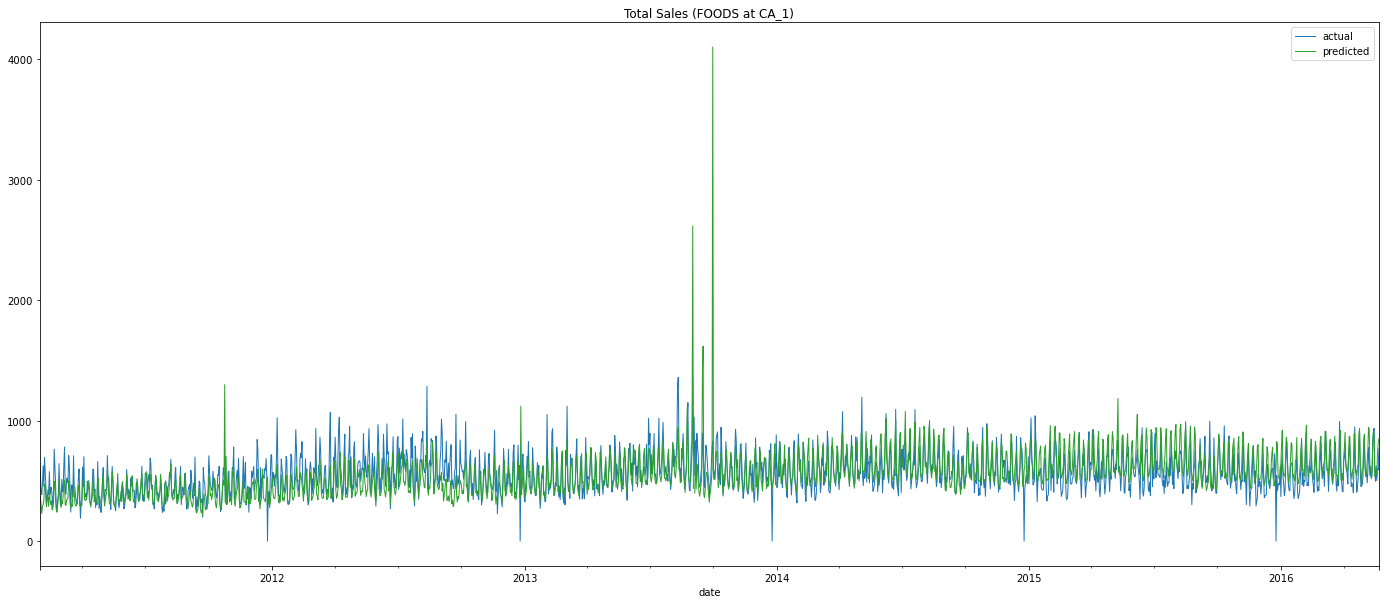

In [85]:
tot_p = o1.groupby("date").sum()
tot_p = tot_p[tot_p<1e5]
fig, ax = plt.subplots(figsize=(24, 10))
tot_p['actual'].plot.line(color='C0', ax=ax, linewidth=1)
tot_p['predicted'].plot.line(color='C2', ax=ax, linewidth=1)
ax.set_title("Total Sales (FOODS at CA_1)")
ax.legend()
fig;

## ML model

In [40]:
from xgboost import XGBRegressor

In [41]:
xgb = XGBRegressor(
    objective="count:poisson",
    booster="gbtree",
    reg_alpha=0.01,
    reg_lambda=0.01,
    n_estimators=1000,
    colsample_bytree=0.7,
    max_depth=5, 
    learning_rate=0.1, 
    random_state=42,
)

In [42]:
xgb.fit(x.loc[train], y.loc[train])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0.699999988, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1,
             objective='count:poisson', random_state=42, reg_alpha=0.01,
             reg_lambda=0.01, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
xgb.feature_importances_

array([0.01295117, 0.00411029, 0.01574104, 0.04432853, 0.04621621,
       0.04648463, 0.03053215, 0.0079377 , 0.00157938, 0.00181947,
       0.0012928 , 0.00129273, 0.00201432, 0.00249804, 0.00168271,
       0.00250148, 0.00168924, 0.00293665, 0.00282823, 0.46428466,
       0.19754319, 0.10773533], dtype=float32)

In [54]:
from xgboost import plot_importance

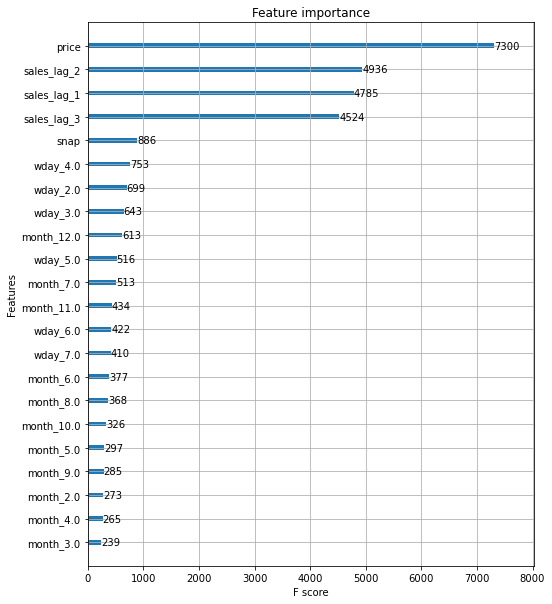

In [59]:
fig, ax = plt.subplots(figsize=(8, 10))
plot_importance(xgb, ax=ax);

In [43]:
z2 = xgb.predict(x.loc[valid])

/home/anatoly/miniconda3/envs/m5-comp/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [44]:
o2 = pd.DataFrame({"actual": y.loc[valid], "predicted": z2})

In [45]:
items = o2.index.levels[1]
N = len(items)

In [47]:
eg = pd.DataFrame({"MAE": [], "Relative MAE": []})
# pd.Series({"Total": }, name='MAE')
_m1 = (o2['actual']-o2['predicted']).abs().mean()
eg.loc["Overall"] = [_m1, _m1 / o2['actual'].mean()]
for i in range(N):
    v = o2.loc[:, items[i], :].groupby("date").sum()
    _m1 = (v["actual"] - v["predicted"]).abs().mean()
    eg.loc[items[i]] = [_m1, _m1 / v['actual'].mean()]
eg

,MAE,Relative MAE
Overall,1.517703,0.628454
FOODS_1_001,0.945738,1.294882
FOODS_1_002,0.635297,1.312947
FOODS_1_003,0.984282,1.112666
FOODS_1_004,4.061227,0.388616
...,...,...
FOODS_3_823,0.762186,0.954419
FOODS_3_824,0.844903,1.251106
FOODS_3_825,0.874829,1.004834
FOODS_3_826,1.450742,0.929757


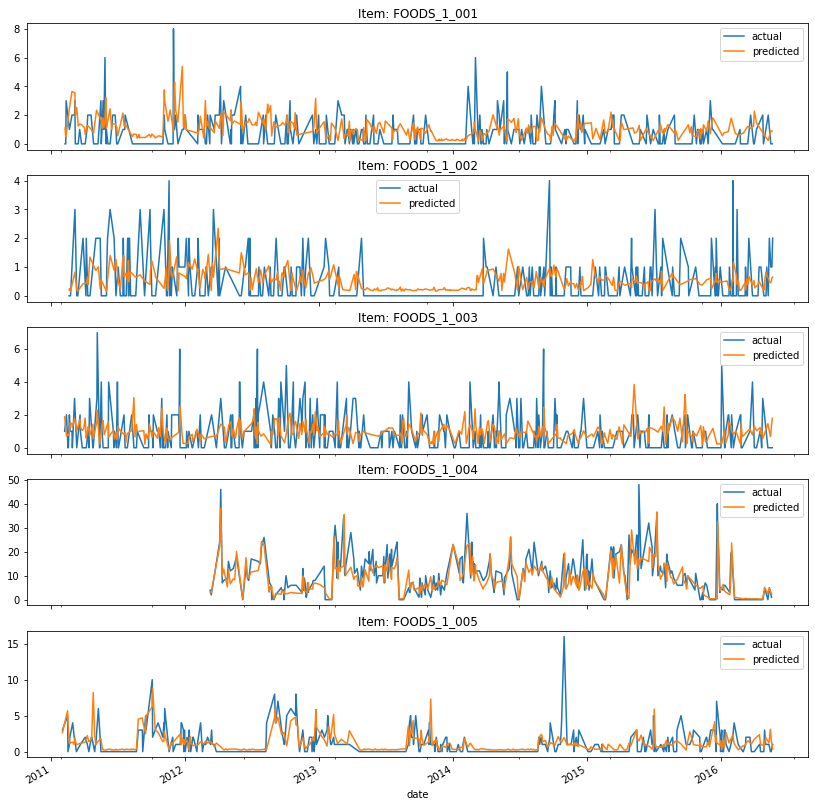

In [51]:
N = min(5, N)
fig, axs = plt.subplots(N, 1, sharex=True, figsize=(14, 3 * N))
for i in range(N):
    ax=axs[i]
    v = o2.loc[:, items[i], :].groupby("date").sum()
    v.plot.line(ax=ax)
    ax.set_title(f"Item: {items[i]}")
    ax.legend()
fig;

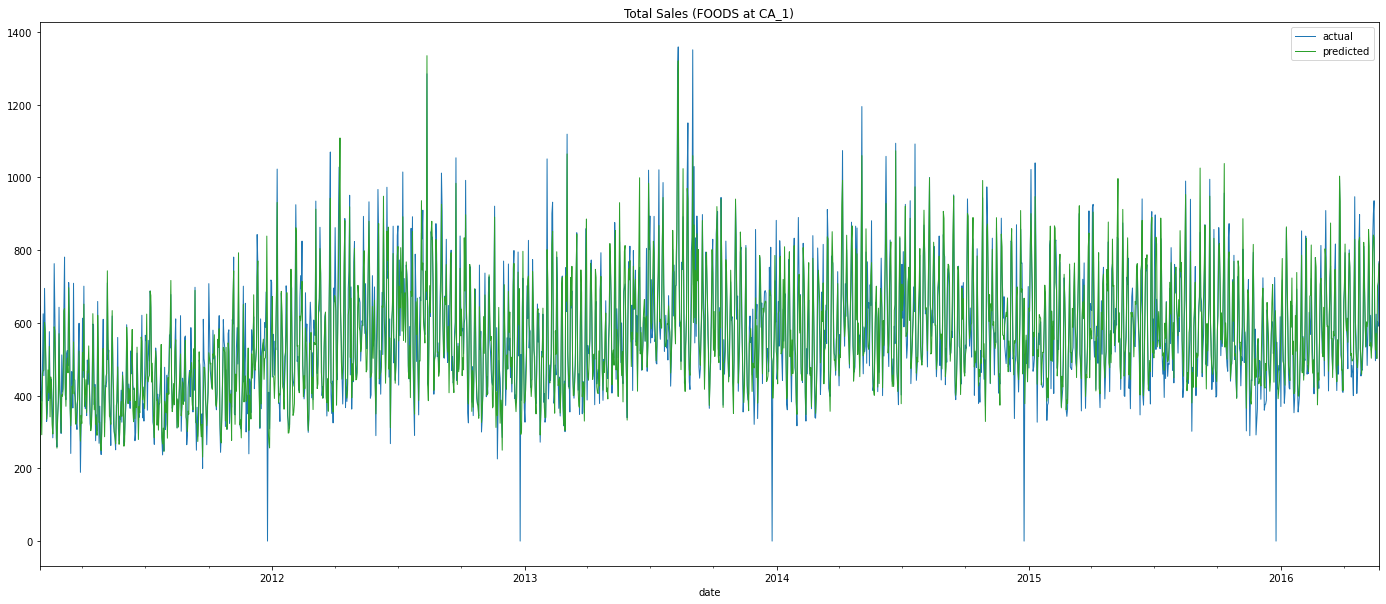

In [73]:
tot_g = o2.groupby("date").sum()
fig, ax = plt.subplots(figsize=(24, 10))
tot_g['actual'].plot.line(color='C0', ax=ax, linewidth=1)
tot_g['predicted'].plot.line(color='C2', ax=ax, linewidth=1)
ax.set_title("Total Sales (FOODS at CA_1)")
ax.legend()
fig;

## PyMC3 Model

In [ ]:
with pm.Model(coords=x.coords) as m:
    for k, v in x.data_vars.items():
        pm.Data(k, v, dims=v.dims)
        
    pm.HalfCauchy('y_mean', beta=2, dims=['item_id'])
    psi = pm.Uniform("psi", lower=0, upper=1)
    theta = m['y_mean'][:, np.newaxis, np.newaxis]
    pm.ZeroInflatedPoisson('y', psi=psi, theta=theta, dims=['item_id', 'store_id', 'date'], observed=m['sales'])

gv = pm.model_to_graphviz(m)
gv

### Fit

In [ ]:
with m:
    trace = pm.sample(draws=200, tune=100, chains=1, target_accept=0.8, return_inferencedata = True)

In [ ]:
with m:
    ppc_raw = pm.sample_posterior_predictive(trace.posterior)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive
# dims = ['sample', 'item_id', 'store_id', 'date']
# coords = {k: x.coords[k] for k in dims if k in x.coords}
# ppc = xr.DataArray(ppc_raw['y'], dims=dims, coords=coords).to_dataset(name='y')

In [ ]:
ppc

In [ ]:
y_hat = ppc['y'].mean(dim=['chain', 'draw'])

In [ ]:
z = xr.merge([x, ppc, ppc.mean(dim=['chain', 'draw']).rename({"y": "y_mean"})])

### Check

In [ ]:
a1 = x['sales'].values.ravel()
a2 = y_hat.values.ravel()
a3 = x['store_id'].values
a3 = np.tile(a3, int(len(a1)/len(a3)))

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
z.plot.scatter('sales', 'y_mean', ax=ax, hue='store_id')
fig;

In [ ]:
(x['sales'] - y_hat).mean(dim=['item_id', 'date'])